# Perceptron Implementation:
---

In this module, I will write my own perceptron model to demonstrate programming concepts and ease of custom machine learning algorithms. The perceptron code itself is in single_neuron.py. The metrics will also be custom programmed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap
import pandas as pd
from single_neuron import Perceptron

# **Phase 1** - Data Processing
Below is a sample of the Diabetes Data Set from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/diabetes).

In [2]:
# Import data from CSV
data_df = pd.read_csv('diabetes_data_upload.csv')

# Convert data frame to numpy array
data = data_df.to_numpy()

data_df[:10]

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
5,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive
6,57,Male,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,No,No,Positive
7,66,Male,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,No,No,Positive
8,67,Male,Yes,Yes,No,Yes,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,Positive
9,70,Male,No,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,No,Yes,No,Positive


## Making Data Machine Readable
Each feature can be re-classified to a 0 or 1, except for age which will be standardized.

Data is standardized using the following equation:

$
\large Z = \dfrac{\bar{X} - \mu}{\sigma}
$

Where $\mu$ is the average and $\sigma$ is the standard deviation.

After age is standardized, the rest of the entries will be made machine readable by classifying any entry as male, yes, true, or positive will be changed to a 1. Any entry with a female, no, false, or negative will be changed to a 0.

## Weights and Bias
The mathematical representation of the perceptron is:

$
\large \hat{y}^{i} = \text{step}(W^{T}\bar{X}^{i} + B)
$

Where $\bar{X}^{i}$ is the feature vector $i$, $W$ are the weights, and $B$ is the bias. The Bias acts as the y-intercept, allowing the perception's linear representation to move vertically. This can be re-written as 

$
\large \hat{y} = \text{step}(X^1*W^1 + X^2*W^2 + ... + X^n*W^n + B)
$

To simplify the equation, we can add on additional $X$ feature with a value of 1, $X^0$, and represent the bias as another weight, $W^0. We can now represent our equation as 

$
\large \hat{y} = \text{step}(X^0*W^0 + X^1*W^1 + ... + X^n*W^n)
$

Which becomes

$
\large \hat{y}^{i} = \text{step}(W^T\bar{X}^i)
$

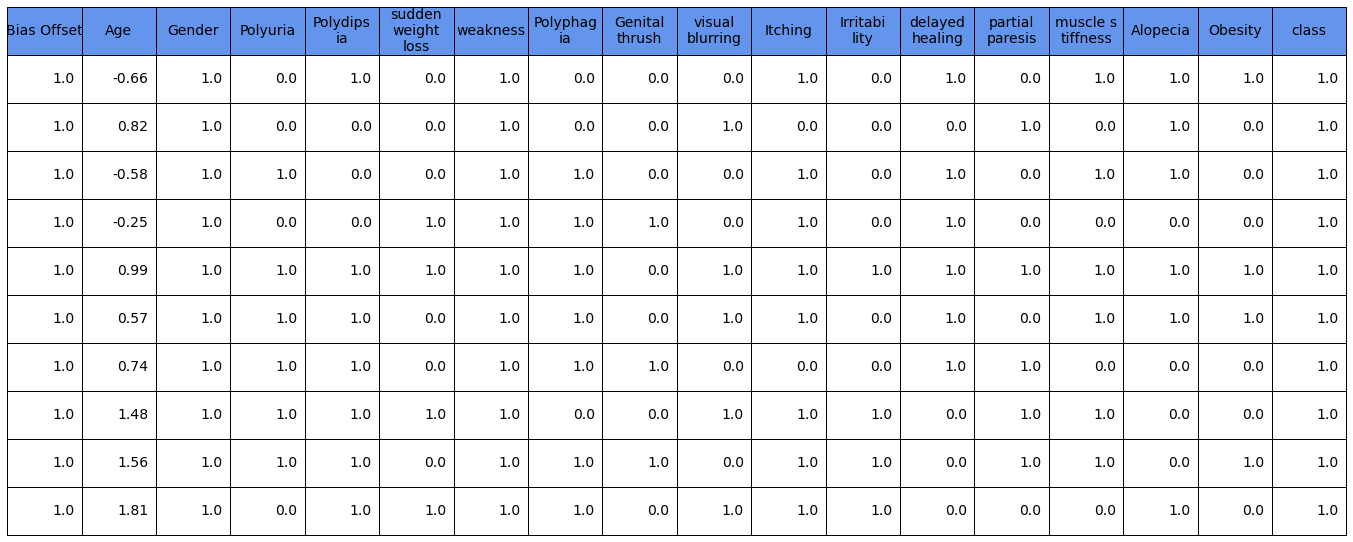

In [3]:
# reset data array incase cell is ran multiple times
data = data_df.to_numpy()

# Calculate average
age_mu = sum(data[:,0])/len(data[:,0])

# Calculate standard deviation
age_sigma = np.sqrt((1/len(data[:,0]))*sum((data[:,0] - age_mu)**2))

# Calculate standardized age
age_stand = (data[:,0] - age_mu)/age_sigma

# Replace the age with the standardized age
data[:,0] = age_stand

# Change text to a 1 or 0
for i in range(len(data[:,0])):
    for j, value in enumerate(data[i,:]):
        # Change true, yes, positive, and male to a 1
        if (value == 'True') or (value == 'Yes') or (value == 'Positive') or (value == 'Male'):
            data[i,j] = 1
        # Change no, negative, female to a 0
        elif (value == 'No') or (value == 'Negative') or (value == 'Female'):
            data[i,j] = 0

# Add a column of ones for the bias
data = np.c_[np.ones(data.shape[0]), data]

# Round the data to fit the table
data = np.round(np.array(data, np.float32), 2)


# Display data in a table
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

# Add column names
label = ['\n'.join(wrap(l, 8)) for l in data_df.columns]

# Name the bias column of 1s
label = ["Bias Offset"] + label

table = plt.table(cellText = data[:10,:], 
                  colLabels = label, 
                  colColours=["cornflowerblue"]*len(data[0,:]), 
                  loc = 'center')

table.scale(4,4)
table.auto_set_font_size(False)
table.set_fontsize(14)

## Partitioning
Next, we will shuffle and partition the data. 

Shuffling allows us to have a random assortment labels in each dataset, limiting the risks of partitioning the data such that most entries are of one label.

Partitioning the data into training, validation, and test sets allows us to set weights, tune hyper-parameters, and judge the effectiveness without biasing the algorithm with data it has trained on. We will partition the data as 50% training, 25% validation, and 25% test. 

After partitioning, we will split the data into features and labels. 

In [4]:
# Shuffle data to provide a mix of labels
for i in range(3):
    np.random.shuffle(data)

# Seperate data into quarters
partition = len(data)/4
partition = np.trunc(partition).astype(int)

# Partition data 50% training, 25% validate, 25% test
train_data = data[:2*partition, :]
test_data = data[2*partition:3*partition+1,:]
validate_data = data[3*partition+1:-1,:]

# Seperate data into inputs...
train_X = train_data[:,:-2]
test_X = test_data[:,:-2]
validate_X = validate_data[:,:-2]

# And Labels
train_y = train_data[:,-1:]
test_y = test_data[:,-1:]
validate_y = validate_data[:,-1:]

# **Phase 2 and 3** - Predict a Result and Train Weights
$
\large w \rightarrow w - \alpha(\hat{y}^{i} - y^{i})\bar{x}^{i}
$

In this phase, we will expose the training data set to the perceptron, predict a label for each feature vector, calculate the error (also called the cost), then update the weights. The train weights element of the Perception class will automatially calculate the optimal weights. Changing the "hist" value to True will return the history of all calculated weights

Initial Cost using sign activation function: [157.]
Minimal Cost using sign activation function: [8.]


Text(0.5, 1.0, 'Error vs Iteration')

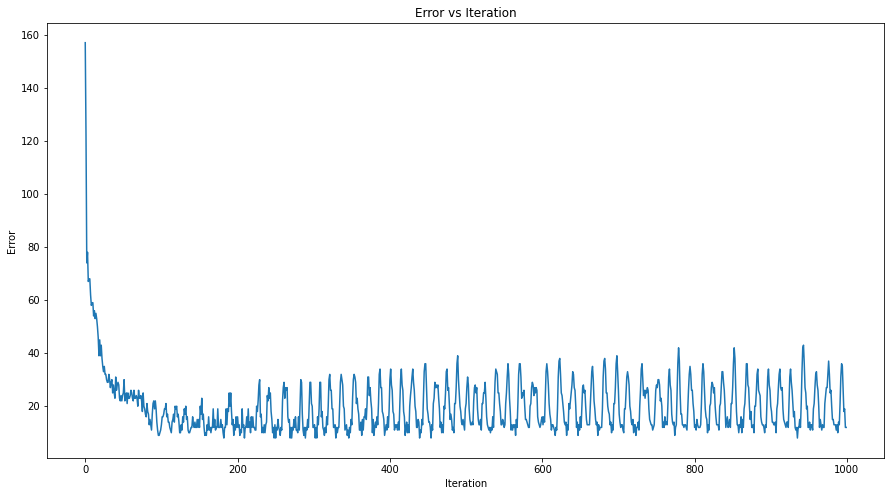

In [5]:
net = Perceptron(train_X.shape[1])
error = net.train_weights(train_X, train_y, hist = True)

plt.figure(figsize=(15,8))
plt.plot(range(error.shape[0]), error)
plt.xlabel("Iteration")
plt.ylabel("Error")
plt.title("Error vs Iteration")



Learning Rate:  0.0001
Initial Cost using sign activation function: [90.]
Minimal Cost using sign activation function: [19.]
Learning Rate:  0.0005
Initial Cost using sign activation function: [74.]
Minimal Cost using sign activation function: [8.]
Learning Rate:  0.001
Initial Cost using sign activation function: [62.]
Minimal Cost using sign activation function: [4.]
Learning Rate:  0.005
Initial Cost using sign activation function: [62.]
Minimal Cost using sign activation function: [1.]
Learning Rate:  0.01
Initial Cost using sign activation function: [43.]
Minimal Cost using sign activation function: [1.]
Learning Rate:  0.05
Initial Cost using sign activation function: [79.]
Minimal Cost using sign activation function: [0.]
Learning Rate:  0.1
Initial Cost using sign activation function: [71.]
Minimal Cost using sign activation function: [0.]
Learning Rate:  0.5
Initial Cost using sign activation function: [74.]
Minimal Cost using sign activation function: [0.]
Learning Rate:  1
I

[Text(0.5, 0, 'Alpha')]

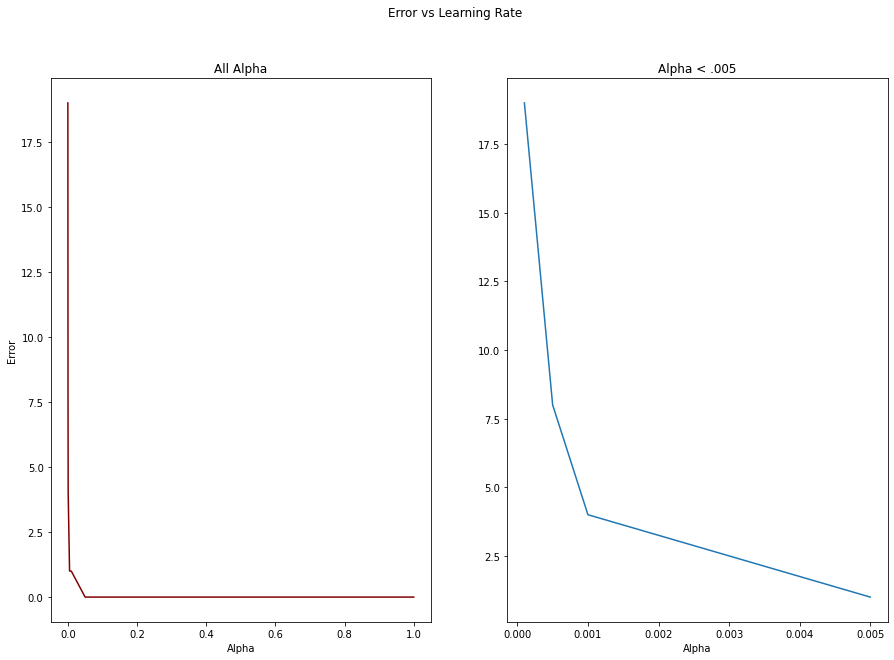

In [6]:
alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
all_errors = []
min_errors = []

# Adjust hyper-parameters and save erros
for alpha in alphas:
    print("Learning Rate: ", alpha)
    net_validate = Perceptron(validate_X.shape[1], alpha=alpha)
    errors = net_validate.train_weights(validate_X, validate_y, hist=True)
    all_errors.append(errors)

# Find the lowest error
all_errors = np.array(all_errors)
i = np.argwhere(all_errors == np.min(all_errors))   
r = i[0,0]
c = i[0,1]

# Optimal alpha is at alpha[r]
net.alpha = alphas[r]
 
for i, a in enumerate(alphas):
    min_indx = np.argwhere(all_errors[i] == np.min(all_errors[i]))
    c = min_indx[0]
    min_errors.append(all_errors[i,c])


# Plot to visualize error vs learning rate
fig, axs = plt.subplots(1,2,figsize = (15,10))
fig.suptitle('Error vs Learning Rate')

axs[0].set_title('All Alpha')
axs[1].set_title('Alpha < .005')

axs[0].plot(alphas, min_errors, 'maroon')
axs[0].set(xlabel = "Alpha", ylabel = "Error")

axs[1].plot(alphas[:4], min_errors[:4])
axs[1].set(xlabel = "Alpha")


# Determine Model Score
## Predict on Unseen Data
Now the weights have been trained using the test set and the hyper parameters have been tuned using the validation set, we are able to determine how well our model predicts using the test data. 

We will begin by using the trained weights to make a prediction on the test data. The table shows each predicted result, actual result, and highlights any incorrect predictions. 

C:\Users\carmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


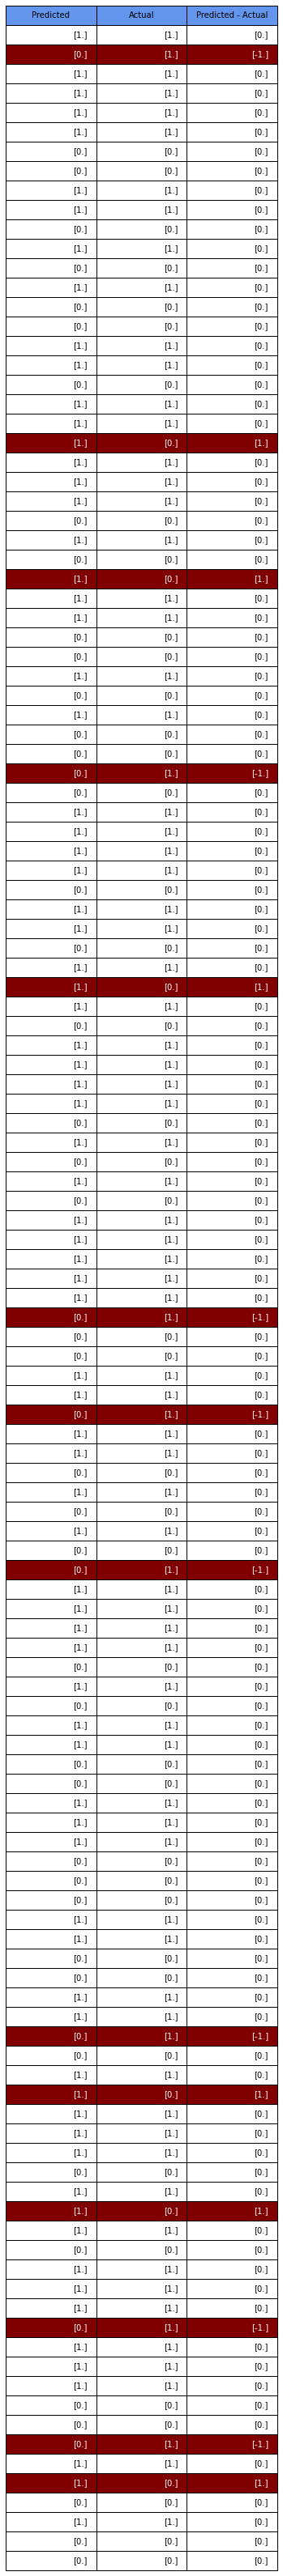

In [7]:
y_hat = net.predict(test_X)
errors = y_hat - test_y

header = ["Predicted", "Actual", "Predicted - Actual"]
table_data = list(zip(y_hat, test_y, errors))

# Display data in a table
fig, ax = plt.subplots()
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = plt.table(cellText = table_data, 
                  colLabels = header, 
                  colColours=["cornflowerblue"]*len(header), 
                  loc = 'center')

table.scale(1,2)

# Highlight incorrect cells and change text color for visibility
for i, error in enumerate(errors):
    if error != 0:
        table[(i+1),0].set_facecolor("maroon")
        table[(i+1),1].set_facecolor("maroon")
        table[(i+1),2].set_facecolor("maroon")

        table[(i+1),0].get_text().set_color('white')
        table[(i+1),1].get_text().set_color('white')
        table[(i+1),2].get_text().set_color('white')


## Classify Predictions and Calculate F score

Then we will classify each prediction as true positive, true negative, false postive, and false negative. A false positive is a predicted positive when the actual output is negative. A false negative is a predicted negative when the actual output is postive. 

Once each prediction is classified, we will calculate the F score using the following equation:

$
\large \text{F1} = 2\times \dfrac{Precision * Recall}{Precision + Recall}
$

Where:
$
\large \text{Precision} = \dfrac{\text{True Positive}}{\text{True Positive + False Positive}}
$

And:
$
\large \text{Recall} = \dfrac{\text{True Positive}}{\text{True Positive + False Negative}}
$

The higher F Score, the better

Perceptron F score is: 0.91


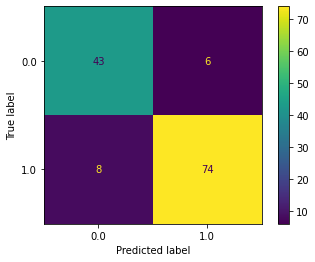

In [8]:
f_pos = f_neg = t_pos = t_neg = 0

# Calculate F1
for i, value in enumerate(errors):
    if value > 0:
        f_pos += 1
    if value < 0:
        f_neg += 1
    if value == 0 and y_hat[i] == 1:
        t_pos += 1
    if value == 0 and y_hat[i] == 0:
        t_neg += 1

precision = t_pos/(t_pos + f_pos)
recall = t_pos/(t_pos + f_neg)

f_score = 2*(precision * recall)/(precision + recall)

print(f"Perceptron F score is: {np.round(f_score, 2)}")

from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(test_y, y_hat)

## Phase 4: Model Comparison

The scores for classification models are below:
- Perceptron: .94
- MLP: 1 (Tanh, ReLU)
- Logistic Regression: .95
- Decision Tree: .99
- KNN: .97
- SVM: .93

The best performing model is the MLP with a F score of 1 and no misslabeled classificatinos. The decision tree, however has and F score of .99 with 1 mislabeled classification. While technically worse, the decision tree model comes very close and is much more intuitive. This is where the application and client are important considerations in model selection. For example, in a medical scenario a doctor may want to understand every aspect of how a decision about a patient was made. Unless a tool is extensively tested with 100% accuracy at every stage, it is hard to overcome ones own intuition, especially if the responsibility of a life lays on the decision maker. The ability to understand a model vs the accuracy and recall of a model are important considerations and the impact to the client must be considered.

